In [33]:
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

import numpy as np

## Exploratory Data Analysis

In [34]:
# load in df
df = pd.read_csv('stats.csv')
df.head()

,"last_name, first_name",player_id,year,ab,pa,home_run,strikeout,walk,k_percent,bb_percent,...,b_swinging_strike,woba,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent
0,"Beltré, Adrian",134181,2017,340,389,17,52,39,13.4,10.0,...,122,0.384,0.358,36.1,5.8,32.5,97.066970,92.551073,18.7,46.8
1,"Beltrán, Carlos",136860,2017,467,509,14,102,33,20.0,6.5,...,146,0.283,0.284,29.4,4.6,31.0,97.251447,92.653848,19.8,47.9
2,"Werth, Jayson",150029,2017,252,289,10,69,35,23.9,12.1,...,92,0.311,0.329,33.2,8.2,40.7,99.992580,94.104058,21.9,38.6
3,"Arroyo, Bronson",276520,2017,26,29,0,10,0,34.5,0.0,...,10,0.135,0.210,36.8,0.0,0.0,89.654834,89.315833,26.2,50.0
4,"Dickey, R.A.",285079,2017,61,68,0,12,0,17.6,0.0,...,17,0.129,0.139,19.6,0.0,0.0,83.338039,88.117691,14.8,74.3


In [35]:
# shape of dataset
rows, cols = df.shape[0], df.shape[0]

print(f'Number of Rows: {rows}')
print(f'Number of Columns: {cols}')

Number of Rows: 5419
Number of Columns: 5419


In [36]:
# all columns
print(df.columns)

Index(['last_name, first_name', 'player_id', 'year', 'ab', 'pa', 'home_run',
       'strikeout', 'walk', 'k_percent', 'bb_percent', 'batting_avg',
       'slg_percent', 'on_base_percent', 'on_base_plus_slg', 'b_rbi',
       'b_swinging_strike', 'woba', 'xwoba', 'sweet_spot_percent',
       'barrel_batted_rate', 'hard_hit_percent', 'avg_best_speed',
       'avg_hyper_speed', 'whiff_percent', 'swing_percent'],
      dtype='object')


## Train/Test Split

In [37]:
from sklearn.model_selection import train_test_split

# remove non-numeric columns
id_cols = [col for col in df.columns if 'name' in col.lower() or 'id' in col.lower()]
df = df.drop(columns=id_cols, errors='ignore')

y = df['home_run']
X = df.drop(columns=['home_run'])

# split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (4335, 22)
Test shape: (1084, 22)


## Random Forest

In [38]:
results = []

for n_est in [50, 200, 500]:
    for depth in [3, 8, 15]:
        rf = RandomForestRegressor(n_estimators=n_est, max_depth=depth, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_train_pred = rf.predict(X_train)
        y_test_pred  = rf.predict(X_test)
        train_r2   = r2_score(y_train, y_train_pred)
        test_r2    = r2_score(y_test,  y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))
        train_mae  = mean_absolute_error(y_train, y_train_pred)
        test_mae   = mean_absolute_error(y_test,  y_test_pred)

        results.append({"n_estimators": n_est, "max_depth": depth, "Train R²": train_r2, "Test R²": test_r2, "Train RMSE": train_rmse,
            "Test RMSE": test_rmse, "Train MAE": train_mae,"Test MAE": test_mae})

variant1_results = pd.DataFrame(results)
variant1_results.sort_values(by="Test R²", ascending=False)

,n_estimators,max_depth,Train R²,Test R²,Train RMSE,Test RMSE,Train MAE,Test MAE
2,50,15,0.993751,0.958440,0.762849,2.006480,0.515071,1.352271
5,200,15,0.994240,0.958376,0.732383,2.008028,0.499400,1.354045
8,500,15,0.994343,0.958265,0.725813,2.010697,0.494630,1.354412
4,200,8,0.979743,0.953905,1.373465,2.113109,0.994147,1.440483
7,500,8,0.979727,0.953726,1.374027,2.117220,0.993950,1.444125
1,50,8,0.979333,0.953489,1.387314,2.122641,1.001241,1.436507
3,200,3,0.905891,0.900785,2.960392,3.100167,2.076432,2.189854
6,500,3,0.905625,0.900443,2.964578,3.105504,2.080088,2.191907
0,50,3,0.905152,0.900323,2.972003,3.107385,2.085844,2.190693


In [24]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
corr_threshold = 0.85
to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
print(f"Features to drop due to high correlation (>|{corr_threshold}|):")
print(to_drop)

Features to drop due to high correlation (>|0.85|):
['pa', 'strikeout', 'walk', 'on_base_percent', 'on_base_plus_slg', 'b_rbi', 'b_swinging_strike', 'woba', 'xwoba', 'avg_best_speed', 'avg_hyper_speed']


In [39]:
X_train_reduced = X_train.drop(columns=to_drop)
X_test_reduced = X_test[X_train_reduced.columns]

best_params = {"n_estimators": 200, "max_depth": 8}

rf_reduced = RandomForestRegressor(**best_params, random_state=42,n_jobs=-1)

rf_reduced.fit(X_train_reduced, y_train)
y_train_pred = rf_reduced.predict(X_train_reduced)
y_test_pred  = rf_reduced.predict(X_test_reduced)

train_r2   = r2_score(y_train, y_train_pred)
test_r2    = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))
train_mae  = mean_absolute_error(y_train, y_train_pred)
test_mae   = mean_absolute_error(y_test,  y_test_pred)

results_v2 = pd.DataFrame({"Dataset": ["Train", "Test"], "R²": [train_r2, test_r2], "RMSE": [train_rmse, test_rmse],"MAE": [train_mae, test_mae]})
results_v2

,Dataset,R²,RMSE,MAE
0,Train,0.980974,1.331099,0.952245
1,Test,0.954339,2.103148,1.405310


In [41]:
correlations = df.corr(numeric_only=True)['home_run'].abs().sort_values(ascending=False)
top10_features = correlations.index[1:11]
print("Top 10 correlated features:", list(top10_features))

X_train_base = X_train[top10_features]
X_test_base = X_test[top10_features]
X_train_complex = X_train_reduced 
X_test_complex = X_test_reduced   


rf_baseline = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_base, y_train)
rf_complex = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
rf_complex.fit(X_train_complex, y_train)

Top 10 correlated features: ['b_rbi', 'b_swinging_strike', 'strikeout', 'pa', 'ab', 'walk', 'slg_percent', 'on_base_plus_slg', 'xwoba', 'woba']


RandomForestRegressor(max_depth=8, n_estimators=200, n_jobs=-1, random_state=42)

In [42]:
def get_metrics(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    return {
        "Train R²": r2_score(y_train, y_train_pred),
        "Test R²":  r2_score(y_test,  y_test_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Test RMSE":  np.sqrt(mean_squared_error(y_test,  y_test_pred)),
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Test MAE":  mean_absolute_error(y_test,  y_test_pred),
    }

baseline_metrics = get_metrics(rf_baseline, X_train_base, y_train, X_test_base, y_test)
complex_metrics  = get_metrics(rf_complex, X_train_complex, y_train, X_test_complex, y_test)
comparison = pd.DataFrame({
    "Baseline Model (Top 10)": baseline_metrics,
    "Complex Model (Tuned + Feature Selection)": complex_metrics
}).T

comparison


,Train R²,Test R²,Train RMSE,Test RMSE,Train MAE,Test MAE
Baseline Model (Top 10),0.937400,0.924304,2.414472,2.707902,1.693183,1.868223
Complex Model (Tuned + Feature Selection),0.980974,0.954339,1.331099,2.103148,0.952245,1.405310


## Decision Tree

Model Variant 1: Only use the top 10 correlated features with `home_run`

In [17]:
correlations = df.corr()['home_run'].abs().sort_values(ascending=False)
top10 = correlations.index[1:11]

X_train_top10 = X_train[top10]
X_test_top10 = X_test[top10]

print("Top 10 correlated features:", list(top10))

Top 10 correlated features: ['b_rbi', 'b_swinging_strike', 'strikeout', 'pa', 'ab', 'walk', 'slg_percent', 'on_base_plus_slg', 'xwoba', 'woba']


In [18]:
# Fit Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

dt_top10 = DecisionTreeRegressor(
    max_depth=5,
    min_samples_leaf=10,
    random_state=42
)

dt_top10.fit(X_train_top10, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [19]:
# Evaluate model performance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

y_train_pred = dt_top10.predict(X_train_top10)
y_test_pred = dt_top10.predict(X_test_top10)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# merge all metrics into a single df
metrics_table = pd.DataFrame({
    "Train": [train_r2, train_rmse, train_mae],
    "Test": [test_r2, test_rmse, test_mae]
}, index=["R²", "RMSE", "MAE"])

metrics_table

,Train,Test
R²,0.916609,0.897509
RMSE,2.786719,3.150940
MAE,1.918584,2.133808


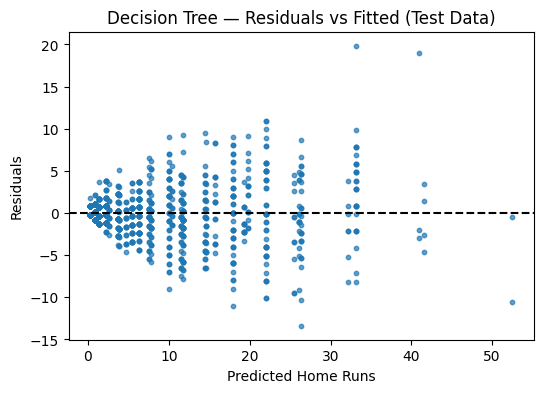

In [20]:
# Plot residual plot
import matplotlib.pyplot as plt

residuals = y_test - y_test_pred

plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, s=10, alpha=0.7)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Predicted Home Runs")
plt.ylabel("Residuals")
plt.title("Decision Tree — Residuals vs Fitted (Test Data)")
plt.show()

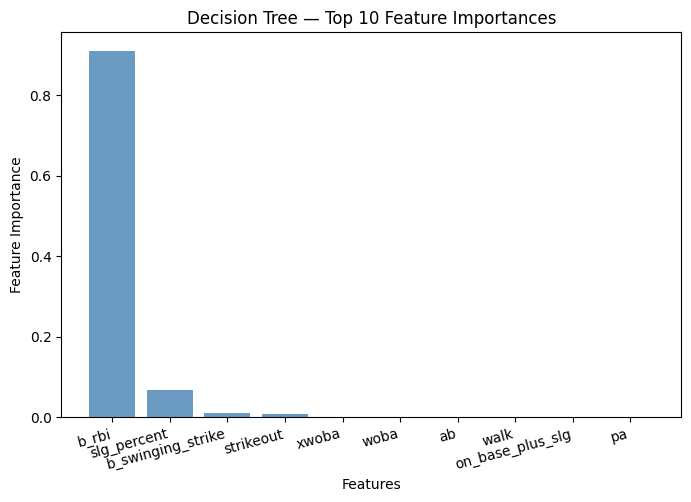

In [21]:
# Plot model feature importances
feature_importances = dt_top10.feature_importances_
orders_ft = np.argsort(feature_importances)[::-1]
features_sorted = [X_train_top10.columns[i] for i in orders_ft]
importances_sorted = feature_importances[orders_ft]

plt.figure(figsize=(8,5))
bars = plt.bar(features_sorted, importances_sorted, color='steelblue', alpha=0.8)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.title("Decision Tree — Top 10 Feature Importances")
plt.xticks(rotation=15, ha="right")
plt.show()

## MLR

MODEL VARIANT : FINDING THE BEST NUMBER OF FEATURES BASED ON TOP 10 CORRELATED with `home_run`

In [13]:
# TOP CORRELATED FEATURES 
corr_with_y = X_train.join(y_train).corr(numeric_only=True)['home_run'].drop('home_run')
corr_sorted = corr_with_y.sort_values(ascending=False)
k = 10
top_features = corr_sorted.head(k).index.tolist()
top_features


['b_rbi',
 'b_swinging_strike',
 'pa',
 'strikeout',
 'ab',
 'walk',
 'slg_percent',
 'on_base_plus_slg',
 'xwoba',
 'woba']

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Finding the best number of features from top 10 correlated features
results = []

for k in range(10, 0, -1):  
    feats = top_features[:k]
    lr = LinearRegression()
    lr.fit(X_train[feats], y_train)
    
    
    y_pred_train = lr.predict(X_train[feats])
    y_pred_test  = lr.predict(X_test[feats])
    
    
    rmse_train = mean_squared_error(y_train, y_pred_train)
    rmse_test  = mean_squared_error(y_test, y_pred_test)
    r2_train   = r2_score(y_train, y_pred_train)
    r2_test    = r2_score(y_test, y_pred_test)
    
    results.append({
        'k': k,
        'features': feats,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'r2_train': r2_train,
        'r2_test': r2_test
    })

cv_df = pd.DataFrame(results)
cv_df

,k,features,rmse_train,rmse_test,r2_train,r2_test
0,10,"[b_rbi, b_swinging_strike, pa, strikeout, ab, ...",6.999972,7.857864,0.924833,0.918883
1,9,"[b_rbi, b_swinging_strike, pa, strikeout, ab, ...",7.006372,7.857426,0.924764,0.918888
2,8,"[b_rbi, b_swinging_strike, pa, strikeout, ab, ...",7.115298,7.849130,0.923595,0.918973
3,7,"[b_rbi, b_swinging_strike, pa, strikeout, ab, ...",8.272207,9.468016,0.911171,0.902262
4,6,"[b_rbi, b_swinging_strike, pa, strikeout, ab, ...",8.766008,9.878907,0.905869,0.898020
5,5,"[b_rbi, b_swinging_strike, pa, strikeout, ab]",8.960902,10.272979,0.903776,0.893952
6,4,"[b_rbi, b_swinging_strike, pa, strikeout]",9.576345,11.362762,0.897167,0.882702
7,3,"[b_rbi, b_swinging_strike, pa]",10.026387,11.629275,0.892335,0.879951
8,2,"[b_rbi, b_swinging_strike]",12.181986,13.871013,0.869188,0.856809
9,1,[b_rbi],12.557500,14.574701,0.865155,0.849545


In [26]:
best_row = cv_df.sort_values('rmse_test').iloc[0]
k_best = best_row['k']
best_row, k_best

(k                                                             8
 features      [b_rbi, b_swinging_strike, pa, strikeout, ab, ...
 rmse_train                                             7.115298
 rmse_test                                               7.84913
 r2_train                                               0.923595
 r2_test                                                0.918973
 Name: 2, dtype: object,
 np.int64(8))

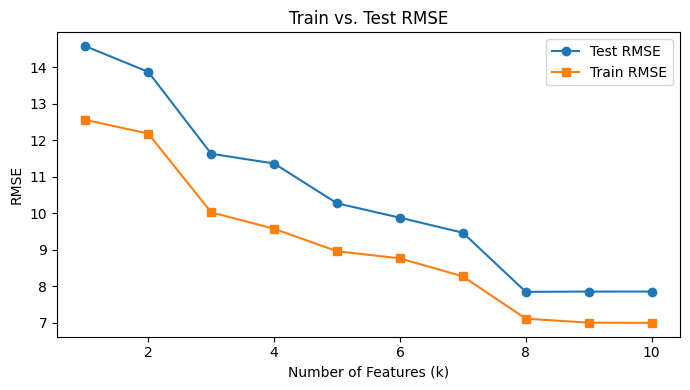

In [ ]:
#Features vs RMSE SCORES
plt.figure(figsize=(7,4))
plt.plot(cv_df['k'], cv_df['rmse_test'], marker='o', label='Test RMSE')
plt.plot(cv_df['k'], cv_df['rmse_train'], marker='s', label='Train RMSE')
plt.xlabel('Number of Features (k)')
plt.ylabel('RMSE')
plt.title('Train vs. Test RMSE')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# OPTIMAL NUMBER OF FEATURES MODEL
summary_table = pd.DataFrame({
    'Metric': ['# of Features (k)', 'Train RMSE', 'Test RMSE', 'Train R²', 'Test R²'],
    'Value': [
        k_best,
        round(best_row['rmse_train'], 3),
        round(best_row['rmse_test'], 3),
        round(best_row['r2_train'], 3),
        round(best_row['r2_test'], 3)
    ]
})
summary_table

,Metric,Value
0,# of Features (k),8.000
1,Train RMSE,7.115
2,Test RMSE,7.849
3,Train R²,0.924
4,Test R²,0.919
